In [1]:
from transformers import BertTokenizer
from razdel import sentenize
import torch
from torch import nn
import numpy as np
import pandas as pd
import tqdm
import json
import pickle
import os
import io
import matplotlib.pyplot as plt

In [2]:
import neptune
import telebot

In [3]:
neptune.init(
    project_qualified_name='leshanbog/small-encoder-clustering',
    api_token='=', 
)


Project(leshanbog/small-encoder-clustering)

In [4]:
DEVICE = 'cuda:5'
MAX_LEN = 200
UNK, PAD = "UNK", "PAD"

## Dataset

In [5]:
from torch.utils.data import Dataset, DataLoader

In [6]:
class TelegramRegressionReader(Dataset):
    def __init__(self, txt_path, vec_path, chunk_size=2048):
        self.txt_path = txt_path
        self.vec_path = vec_path

        self.shift = 3200 # numpy load reads 3200 bytes from file handler which is equal one vector
        
        self.chunk_size = chunk_size
        
        self.size = sum(
            len(el) for el in pd.read_json(
                self.txt_path,
                encoding='utf-8',
                lines=True,
                chunksize=chunk_size)
        )
        
        s = [0]
        with open(txt_path, 'r', encoding='utf-8') as f:
            self.txt_linelocs = [s.append(s[0]+len(n)+1) or s.pop(0) for n in f]
            
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        with open(self.txt_path, 'r', encoding='utf-8') as f_txt,\
             open(self.vec_path, 'rb') as f_vec:
            f_txt.seek(self.txt_linelocs[idx], 0)
            txt = f_txt.readline()

            f_vec.seek(self.shift * idx, 0)
            vec = np.load(f_vec).reshape(1, -1)
            
            return {'text': txt, 'vector': vec}

In [7]:
train = TelegramRegressionReader('/data/alolbuhtijarov/datasets/BertSumAbs_predictions/split/train_texts.jsonl',
                                '/data/alolbuhtijarov/datasets/BertSumAbs_predictions/split/train_vec.npy')

test = TelegramRegressionReader('/data/alolbuhtijarov/datasets/BertSumAbs_predictions/split/test_texts.jsonl',
                                '/data/alolbuhtijarov/datasets/BertSumAbs_predictions/split/test_vec.npy')

val = TelegramRegressionReader('/data/alolbuhtijarov/datasets/BertSumAbs_predictions/split/val_texts.jsonl',
                              '/data/alolbuhtijarov/datasets/BertSumAbs_predictions/split/val_vec.npy')

In [8]:
len(train), len(val), len(test)

(456939, 14231, 9813)

In [9]:
BATCH_SIZE = 256

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(val, batch_size=512, num_workers=8, pin_memory=True)
test_loader = DataLoader(test, batch_size=512, num_workers=8, pin_memory=True)

## Vocabulary

In [10]:
from collections import Counter
from nltk.tokenize import wordpunct_tokenize

In [11]:
def dict_to_raw_txt(txt_dict):
    return txt_dict['text'] + ' ' + txt_dict['title']

def dict_to_token_list(txt_dict):
    return wordpunct_tokenize(dict_to_raw_txt(txt_dict).replace('\xa0', ' ').lower().strip())

def sample_to_token_list(sample):
    return dict_to_token_list(json.loads(sample['text']))

### Using word vocabulary

In [ ]:
cnt = Counter()
for i in tqdm.trange(len(train)):
    cnt.update(sample_to_token_list(train[i]))

 16%|█▌        | 74252/456939 [01:09<06:24, 995.30it/s] 

In [ ]:
len(cnt)

In [ ]:
tokens = [UNK, PAD] + [el[0] for el in cnt.most_common(50000)]
token_to_id = {t: i for i, t in enumerate(tokens)}

### Using subword vocabulary

In [12]:
from subword_nmt.apply_bpe import BPE

bpe_rules_path = '/data/alolbuhtijarov/datasets/BertSumAbs_predictions/bpe_rules'

bpe = BPE(open(bpe_rules_path))

In [13]:
tokens = set()

for i in tqdm.trange(len(train)):
    token_list = sample_to_token_list(train[i])
    tokens.update(bpe.segment_tokens(token_list))

100%|██████████| 456939/456939 [08:08<00:00, 935.72it/s] 


In [14]:
tokens = list(tokens)

In [15]:
tokens = [UNK, PAD] + list(tokens)
token_to_id = {t: i for i, t in enumerate(tokens)}

In [16]:
len(tokens)

51259

### Encoder with pretrained FastText embeddings

In [17]:
import fasttext

In [18]:
ft = fasttext.load_model('/data/alolbuhtijarov/fasttext_pretrained/cc.ru.300.bin')

In [19]:
def remove_separator_symbol_for_subword(w):
    if w.endswith('@@'):
        return w[:-2]
    return w

In [20]:
vocab_token_vectors = torch.FloatTensor([
    ft.get_word_vector(remove_separator_symbol_for_subword(w)) for w in tokens
])

vocab_token_vectors.shape

torch.Size([51259, 300])

In [21]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

In [22]:
#vocab_token_vectors[UNK_IX] = 0
vocab_token_vectors[PAD_IX] = 0

In [23]:
# remove 'bpe.segment_tokens' if not subwords

tokenize_raw_txt = lambda txt: bpe.segment_tokens(wordpunct_tokenize(txt.replace('\xa0', ' ').lower().strip()))

In [24]:
def json_txt_to_input_inds(json_dict_txt):
    tokens = tokenize_raw_txt(dict_to_raw_txt(json.loads(json_dict_txt)))
    if len(tokens) < MAX_LEN:
        tokens = tokens + [PAD] * (MAX_LEN - len(tokens))

    return torch.LongTensor([token_to_id.get(word, UNK_IX) for word in tokens[:MAX_LEN]])

In [25]:
def batch_to_torch_x_y(batch):
    x = list(map(json_txt_to_input_inds, batch['text']))
    x = torch.cat(x).view(-1, MAX_LEN).to(DEVICE)
    y = torch.FloatTensor(batch['vector']).squeeze(1).to(DEVICE)
    return x, y


def raw_txt_to_input_inds(txt):
    tokens = tokenize_raw_txt(txt)
    if len(tokens) < MAX_LEN:
        tokens = tokens + [PAD] * (MAX_LEN - len(tokens))

    return torch.LongTensor([token_to_id.get(word, UNK_IX) for word in tokens[:MAX_LEN]])

In [26]:
def print_metrics(model, data_loader, batch_size=256, mode='VAL'):
    cos_loss_val = 0
    mae_loss_val = 0
    mse_loss_val = 0
    
    cos_loss = nn.CosineEmbeddingLoss(reduction='sum')
    mae_loss = nn.L1Loss(reduction='sum')
    mse_loss = nn.MSELoss(reduction='sum')
    
    num_samples = 0
    
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            x, y = batch_to_torch_x_y(batch)
            batch_pred = model(x)
            
            num_samples += len(y)
            
            cos_loss_val += cos_loss(batch_pred, y, torch.ones(len(y)).to(DEVICE)).item()
            mae_loss_val += mae_loss(batch_pred, y).item()
            mse_loss_val += mse_loss(batch_pred, y).item()

    print('MSE:', round(mse_loss_val / num_samples, 6))
    print('MAE:', round(mae_loss_val / num_samples, 6))
    print('COS:', round(cos_loss_val / num_samples, 6))
    
    neptune.log_metric(mode + ' MSE', mse_loss_val / num_samples)
    neptune.log_metric(mode + ' MAE', mae_loss_val / num_samples)
    neptune.log_metric(mode + ' COS', cos_loss_val / num_samples)
    
    return cos_loss_val / num_samples


def plot_cos_loss(scores, to_neptune=False):
    if to_neptune:
        figure, ax = plt.subplots(figsize=(10, 7))
        ax.scatter(*zip(*scores['train_all']), alpha=0.09, c='b')
        ax.plot(*zip(*scores['train']), c='b', label='Train COS')
        ax.plot(*zip(*scores['dev']), c='r', label='Dev COS')
        ax.set_ylim(top=0.4); ax.legend(); ax.grid();
        neptune.log_image('Train plot', figure)
    else:
        plt.scatter(*zip(*scores['train_all']), alpha=0.09, c='b')
        plt.plot(*zip(*scores['train']), c='b', label='Train COS')
        plt.plot(*zip(*scores['dev']), c='r', label='Dev COS')
        plt.ylim(top=0.4); plt.legend(); plt.grid(); plt.show()

In [27]:
class SmallEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens),
                 hid_size=256):
        super().__init__()
        
        self.embed = nn.Embedding.from_pretrained(vocab_token_vectors, freeze=False)
        
        self.lstm = nn.LSTM(300, hid_size, 
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        
        self.ff = nn.Linear(2 * hid_size, 768)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.3)
        self.predictor = nn.Linear(768, 768)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.embed(x)
        _, (x, _) = self.lstm(x)
        x = x.permute((1, 0, 2)).reshape(batch_size, -1)
        x = self.ff(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.predictor(x)
        return x

In [28]:
from IPython.display import clear_output

In [29]:
def train_model(model, train_loader, val_loader, 
                criterion, optimizer, scores,
                epochs=500, early_stopping=True, patience=10):
    best_loss_so_far = float('inf')
    steps_without_progress = 0
    cos_loss = nn.CosineEmbeddingLoss(reduction='mean')
    best_state_dict = None
    
    if 'train' not in scores:
        scores['train_all'] = []
        scores['dev'] = []
        scores['train'] = []
    
    for epoch in range(epochs):
        print(f"epoch: {epoch + 1}")
        
        model.train()
        running_mean_cos_loss = None
        for i, batch in tqdm.tqdm(enumerate(train_loader), total=len(train_loader)):
            x, y = batch_to_torch_x_y(batch)
            pred = model(x)

            loss = criterion(pred, y, torch.ones(len(y)).to(DEVICE))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            cos_loss_val = cos_loss(pred, y, torch.ones(len(y)).to(DEVICE)).item()
            if running_mean_cos_loss is None:
                running_mean_cos_loss = cos_loss_val
                
            running_mean_cos_loss = 0.3 * running_mean_cos_loss + 0.7 * cos_loss_val
            
            scores['train_all'].append((epoch, cos_loss_val))

        
        clear_output(True)
        scores['train'].append((epoch, running_mean_cos_loss))
        loss_val = print_metrics(model, val_loader)
        neptune.log_metric('Train COS', running_mean_cos_loss)
        scores['dev'].append((epoch, loss_val))
        
        # plotting
        plot_cos_loss(scores)

        # early stopping handling
        if early_stopping:
            if loss_val < best_loss_so_far:
                best_loss_so_far = loss_val
                steps_without_progress = 0
                best_state_dict = model.state_dict()
            else:
                steps_without_progress += 1

            if steps_without_progress == patience:
                print(f'No progress for {steps_without_progress} iterations! Early stopping...')
                break

    if early_stopping:
        model.load_state_dict(best_state_dict)
    return model

In [30]:
PARAMS = {
    'lr': 5e-4,
    'max_len': MAX_LEN,
    'batch size': BATCH_SIZE,
    'preprocess': '51259 subword tokens; embed init with cc.ru.300.bin'
}

In [31]:
neptune.create_experiment(description='''
class SmallEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens),
                 hid_size=256):
        super().__init__()
        
        self.embed = nn.Embedding.from_pretrained(vocab_token_vectors, freeze=False)
        
        self.lstm = nn.LSTM(300, hid_size, 
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        
        self.ff = nn.Linear(2 * hid_size, 768)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.3)
        self.predictor = nn.Linear(768, 768)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.embed(x)
        _, (x, _) = self.lstm(x)
        x = x.permute((1, 0, 2)).reshape(batch_size, -1)
        x = self.ff(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.predictor(x)
        return x
'''
, params=PARAMS)

psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/leshanbog/small-encoder-clustering/e/SMAL-11


Experiment(SMAL-11)

In [32]:
model = SmallEncoder().to(DEVICE)
criterion = nn.CosineEmbeddingLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=PARAMS['lr'])
scores = dict()

MSE: 1491.656942
MAE: 816.258145
COS: 0.130487


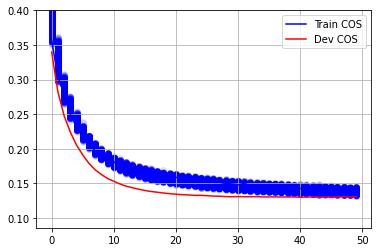

epoch: 51


 29%|██▊       | 512/1785 [02:17<05:36,  3.79it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
%%time

model = train_model(model, train_loader, val_loader, criterion, optimizer, scores)

In [34]:
print_metrics(model, test_loader, mode='TEST');

MSE: 1546.711749
MAE: 831.471248
COS: 0.129091


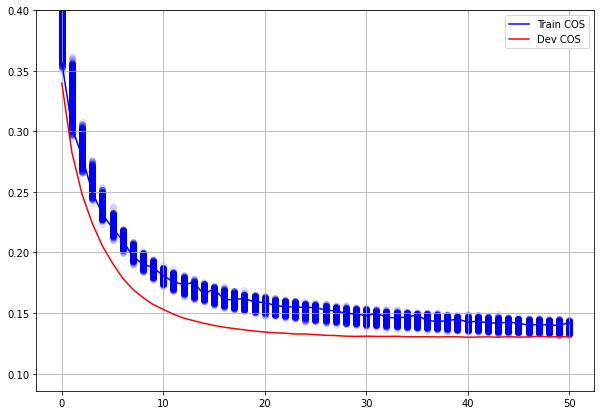

In [35]:
plot_cos_loss(scores, to_neptune=True)

In [36]:
from evaluation.evaluate_clustering import eval_clustering

In [37]:
# import importlib
# import evaluation.evaluate_clustering
# importlib.reload(evaluation.evaluate_clustering)

In [38]:
model.eval()

SmallEncoder(
  (embed): Embedding(51259, 300)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (ff): Linear(in_features=512, out_features=768, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.3, inplace=False)
  (predictor): Linear(in_features=768, out_features=768, bias=True)
)

In [39]:
def txt_to_vec(txt):
    with torch.no_grad():
        vec = model(raw_txt_to_input_inds(txt).to(DEVICE).unsqueeze(0))
    
    return vec.cpu().numpy().flatten()

In [40]:
y_true, y_pred = eval_clustering(txt_to_vec)

10730it [01:05, 163.41it/s]
18it [09:01, 29.48s/it]                        /home/alolbuhtijarov/PreSumm/env_sum/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
19it [09:33, 30.11s/it]/home/alolbuhtijarov/PreSumm/env_sum/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
20it [10:01, 30.08s/it]
100%|██████████| 11/11 [04:52<00:00, 26.56s/it]


Best distance = 0.15943940239955193
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1571
           1       0.90      0.87      0.89      1130

    accuracy                           0.91      2701
   macro avg       0.91      0.90      0.90      2701
weighted avg       0.91      0.91      0.91      2701



In [41]:
from neptunecontrib.monitoring.metrics import log_confusion_matrix

In [42]:
log_confusion_matrix(np.array(y_true), np.array(y_pred))

In [43]:
bot = telebot.TeleBot('')
bot.send_message(420146011, 'READYYYY')

In [44]:
from sklearn.metrics import classification_report

In [45]:
score = classification_report(y_true, y_pred, output_dict=True)

In [46]:
neptune.log_metric('0 precision', score['0']['precision'])
neptune.log_metric('0 recall', score['0']['recall'])
neptune.log_metric('0 f1', score['0']['f1-score'])

In [47]:
neptune.log_metric('1 precision', score['1']['precision'])
neptune.log_metric('1 recall', score['1']['recall'])
neptune.log_metric('1 f1', score['1']['f1-score'])

In [48]:
neptune.log_metric('weighted avg precision', score['weighted avg']['precision'])
neptune.log_metric('weighted avg recall', score['weighted avg']['recall'])
neptune.log_metric('weighted avg f1', score['weighted avg']['f1-score'])

In [49]:
neptune.log_metric('macro avg precision', score['macro avg']['precision'])
neptune.log_metric('macro avg recall', score['macro avg']['recall'])
neptune.log_metric('macro avg f1', score['macro avg']['f1-score'])

In [50]:
neptune.log_metric('Accuracy', score['accuracy'])

In [51]:
neptune.stop()

#### stuff

https://pytorch.org/docs/stable/optim.html#per-parameter-options

In [ ]:
def separate_optimizer(net):
    embed_param = [kv[1] for kv in net.named_parameters() if kv[0] == 'embed.weight']
    model_params = [kv[1] for kv in net.named_parameters() if kv[0] != 'embed.weight']
    opt = torch.optim.Adam([
                {'params': model_params},
                {'params': embed_param, 'lr': 3e-4}
    ], lr=3e-3)
    return opt

In [ ]:
2+2